# Predictive Modelling
This notebook goes through the process of setting up predictive modelling in order to predict salaries for a job opening. This file contains the following steps:

1. Preprocessing Data
2. Training different models
3. Finding the best model with lowest MSE

In [20]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation and Preprocessing

### Loading Files

Previously we cleaned the train csv file and saved as 'train_df_clean.csv'. This file is already consolidated over jobkey_id index. We will also load this file along with the 'test_df.csv'

In [3]:
clean_train_df = pd.read_csv('train_df_clean.csv')
clean_test_df = pd.read_csv('test_features.csv')

### Shuffling Dataframe
Shuffling Dataframe may help to improve cross-validation accuracy

In [4]:
clean_train_df = shuffle(clean_train_df).reset_index(drop=True)

### Define Variables

In [5]:
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

### Get Target Variable

In [6]:
target_df = clean_train_df[target_var]

### One Hot Encoding

In [7]:
def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

In [8]:
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = one_hot_encode_feature_df(clean_test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

## Initializing and Training Predictive Models

Steps:
1. Initializing model lists and dict
2. create models + Hyperparameter tuning
3. Model summary

Models:
1. Linear Regression
2. RandomForestRegressor
3. GradientBoostRegressor

In [9]:
#initializing model lists and dict
models = []
mean_mse = {}
cv_std = {}
res = {}

In [10]:
#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 5

In [11]:
#Initiazlizing Models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, max_features=30, verbose=verbose_lvl)
gb = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)

In [12]:
models.extend([lr, rf, gb])

In [13]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

In [14]:
#cross validate models and print summaries to compare each model
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])


Model:
 LinearRegression()
Average MSE:
 384.4165369737523
Standard deviation during CV:
 0.19655148593614058

Model:
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=150, n_jobs=2, verbose=5)
Average MSE:
 367.9620993999208
Standard deviation during CV:
 0.206840321794715

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=150, verbose=5)
Average MSE:
 357.30055442902335
Standard deviation during CV:
 0.08160377310051103


| Model | Average MSE | SD during CV |
| ---- | ---- | ---- |
| Linear Regression | 384.417 | 0.197 |
| Random Forest | 367.962 | 0.207 |
| Gradient Boost | 357.301 | 0.082 |

We saw the lowest Average Mean Squared Error with Gradient Boost Regressor Model making it the best model among the three used above. 

## Predicting Test Data using Gradient Boost Regressor Model

In [15]:
#selecting Gradient Boost as the preferred model
model = min(mean_mse, key=mean_mse.get)

#train model on entire dataset
model.fit(feature_df, target_df)

#predictions for test df
predictions = model.predict(test_df)

print('\nPredictions calculated using Gradient Boost Regressor.')

      Iter       Train Loss   Remaining Time 
         1        1351.2830           17.11m
         2        1229.8976           18.22m
         3        1129.7084           18.52m
         4        1045.3752           17.78m
         5         974.4283           18.20m
         6         914.9446           18.18m
         7         862.6779           18.77m
         8         814.8460           18.76m
         9         772.9795           18.35m
        10         737.2014           18.97m
        11         703.2007           19.28m
        12         674.8285           19.01m
        13         646.7975           18.77m
        14         622.7268           18.55m
        15         600.2103           18.33m
        16         580.4148           18.15m
        17         562.4582           18.00m
        18         546.1933           17.83m
        19         532.1733           17.66m
        20         519.7989           17.53m
        21         507.6813           17.37m
        2

### Feature Importances

In [16]:
#Saving feature importances
importances = model.feature_importances_

feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

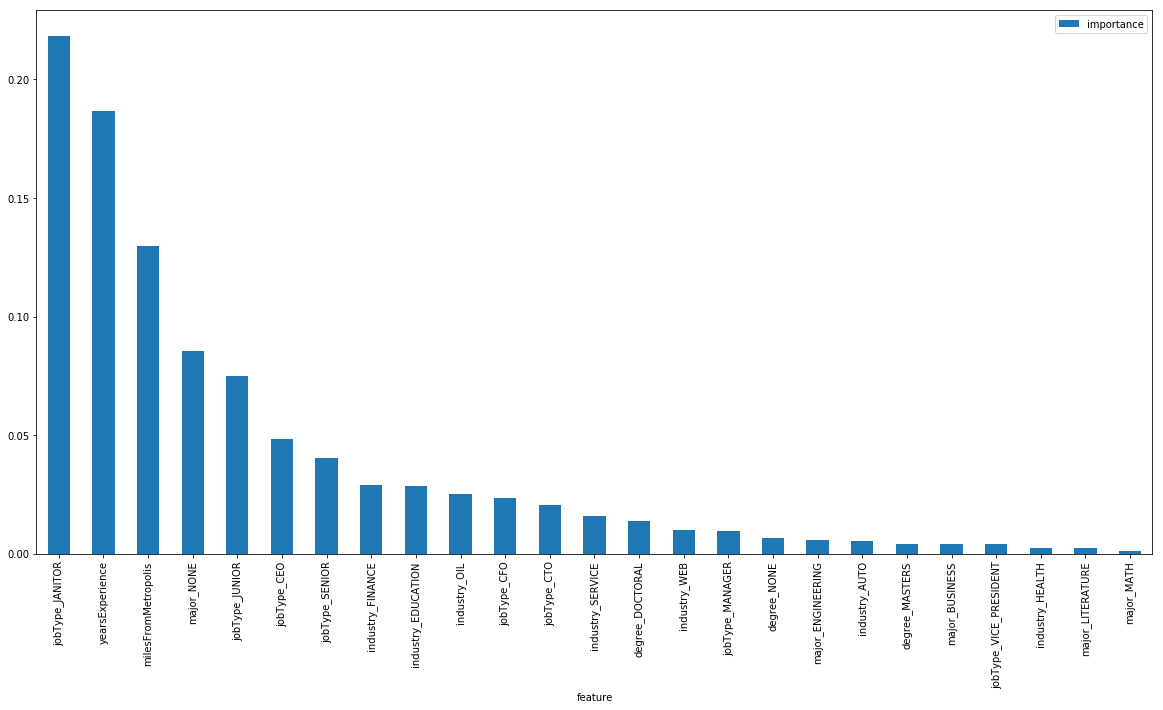

In [21]:
#visualizing Feature Importances
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

### Saving Results

In [23]:
def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

In [24]:
#save results
save_results(model, mean_mse[model], predictions, feature_importances)